In [1]:
cd /home/tkim/Academics/DistMEC_SL/

/home/tkim/Academics/DistMEC_SL


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

from classes.User import *
from classes.solver import *
from classes.Server import *
from classes.distributed_utils import *

from tqdm import tqdm, tqdm_notebook
from time import sleep
import pickle
import os
import numpy as np

In [3]:
def sum_reward_collisions(Users,T, soft_collisions = True, data_mu = None):
    save_array = np.zeros([len(Users),T])
    
    if data_mu is None:
        data_mu = np.ones(len(Users))
    
    for t in range(T-1):
        for u in range(len(Users)):
            
            if soft_collisions:
                scaling = max(Users[u].random_serve_select[t], 1 - Users[u].history_collisions[t])
            else:
                scaling = (1 - Users[u].history_collisions[t])
            distance_scaling = Users[u].history_dist_scale[t]
            save_array[u,t] = scaling * Users[u].history_reward[t] * data_mu[u] * distance_scaling
    
    return save_array

def generate_FL_mu(num_users,num_servers):
    mu = np.zeros([num_users,num_servers])
    svr_mu = np.random.uniform(low=0.3, high = 1, size = num_servers)
    usr_mu = np.random.uniform(low=0.3, high = 1, size = num_users)
    
    for u in range(num_users):
        for s in range(num_servers):
            mu[u,s] = svr_mu[s] * usr_mu[u]
    return mu

In [4]:
# System Parameters
T = 1000
num_users = 80
num_svrs = 80
num_svrs_loc = 80
num_locs = 9
soft_collision = True

num_trial = 5

with open('traces_P_40k.pkl', 'rb') as handle:
    P_collection = pickle.load(handle)

with open('traces_P_40k_dict.pkl', 'rb') as handle:
    P_dict = pickle.load(handle)
        

with open('data_count_80.pkl', 'rb') as handle:
    data = np.array(pickle.load(handle))
    
# Make contextual data_mu 
data_mu = np.clip((data - 0) / (1200 - 100), 0, 1)
data_mu = data_mu[:num_users]
# data_mu = np.ones(data_mu.shape[0])

for nto in range(num_trial):

#     mu = generate_FL_mu(num_users,num_svrs)
    mu = np.random.uniform(low=0.4, high = 1, size = [num_users, num_svrs])
    
    ceiling = 40
    space_1d_dim = 15 #4 for small, 10 for big
    svr_offset_uniform = 0.3
    max_dist = 5

    num_explore = 1
    trials = 1

    # result dictionaries
    result_dicts = []
    performance_list = []
    user_dicts = []

    # Generate visitng locations and server locations
    usr_locs = gen_eq_locs(space_1d=space_1d_dim, nums=num_locs,offset = 1.7)

    # Recording Mechanism
    reward_worst_dict = {}
    collisions_worst_dict = {}

    reward_rsv_dict = {}
    collisions_rsv_dict = {}

    reward_opt_stat = {}


    for tri in range(trials):
        svr_locs = gen_rand_locs(space_1d=space_1d_dim - svr_offset_uniform, nums=num_svrs_loc)
        
        # Create Servers
        Servers = []
        for i in range(num_svrs):
            Servers += [Server(svr_locs[i],mu,i, data_mu)]
            
        # Create Users
        Users_w = []
        for i in range(num_users):
            P_temp = P_collection
            Users_w += [User(usr_locs,svr_locs,mu[i],i,
                          max_dist = max_dist, threshold_dist = 6, self_weight = 1 - 0.75, P = P_temp, ceiling = 1,
                          sticky_mode = True, kick_mode=True,data_mu=data_mu[i])]

        GoT_Users = []
        for i in range(num_users):
            GoT_Users += [GoT_User(usr_locs, svr_locs, mu[i], i, 
                         max_dist = max_dist, threshold_dist = 6, self_weight = 1 - 0.95, P = Users_w[i].P,
                         c1 = 5000, c2 = 6000, c3 = 6000, delta = 0, rho = 0.5, epsilon = 0.1,
                         c = num_users, horizon = T, data_mu = data_mu[i])]


        # Recorded Values - reservation
        regret_g = np.zeros(T) # Got
        collision_count_g = np.zeros(T)
        optimal_reward_g = np.zeros(T)

        regret_w = np.zeros(T) # Worst
        collision_count_w = np.zeros(T)
        optimal_reward = np.zeros(T)

        # Explore rounds are common/shared across all users
        explore_rounds(Users_w, num_users, Servers, mu, regret_w, collision_count_w, optimal_reward,
                       usr_move_flag = True, rounds=num_explore, skip_optimal = True,
                       data_mu = data_mu)
        explore_rounds(GoT_Users, num_users, Servers, mu, regret_w, collision_count_g, optimal_reward,
                       usr_move_flag = True, rounds=num_explore, skip_optimal = True, data_mu = data_mu)

        round_start = ((num_svrs)*num_explore)+1
        copy_usr_loc(Users_w, GoT_Users)

        # Other reward recodings
        Users_rsv = copy.deepcopy(Users_w)
        regret_rsv = copy.deepcopy(regret_w)
        collision_count_rsv = copy.deepcopy(collision_count_w)
        for u in Users_rsv:
            u.sticky_mode = True
            u.kick_mode = True #false
            u.ceiling = ceiling
            u.expected_time_true = u.get_expected_time()

        # Centralized - true w learning
        rewards_record_ct, pulls_record_ct, ucb_ct = extract_centralized_case(Users_w, num_users, num_svrs)
        regret_ct = copy.deepcopy(regret_w)

        # Centralized - stationary w learning
        rewards_record_cs, pulls_record_cs, ucb_cs = extract_centralized_case(Users_w, num_users, num_svrs)
        regret_cs = copy.deepcopy(regret_w)

        # Centralized - stationary w, known mu
        w_stat = obtain_w_stationary(Users_w, num_users, num_svrs)
        optimal_stat_arms, optimal_stat_reward = offline_optimal_action(w_stat,mu,data_mu)
        regret_cst = copy.deepcopy(regret_w)

        for (zzz,t) in zip(tqdm_notebook(range(T-round_start)),range(round_start, T)):
            w = obtain_w(Users_w, len(Users_w), len(Servers))
            optimal = optimal_stat_arms, optimal_stat_reward

            # Distributed solution 
            play_round(Users_w, Servers, mu, regret_w, collision_count_w, 
                       usr_move_flag = True, debugger = False, reservation_mode = False, optimal =optimal,
                      data_mu = data_mu, soft_collision = soft_collision)
            play_round(Users_rsv, Servers, mu, regret_rsv, collision_count_rsv, 
                       usr_move_flag = False, debugger = False, reservation_mode = True, optimal =optimal, t = t,
                      data_mu = data_mu, soft_collision = soft_collision)
            play_round(GoT_Users, Servers, mu, regret_g, collision_count_g, 
                       usr_move_flag = False, debugger=False, reservation_mode = False, optimal=optimal, t = t,
                      arms_override = optimal_stat_arms, data_mu = data_mu, soft_collision = soft_collision)
            copy_usr_loc(Users_w, GoT_Users)
            copy_usr_loc(Users_w, Users_rsv)

    Users_w_sa = sum_reward_collisions(Users_w,T, soft_collision, data_mu)
    Users_rsv_sa = sum_reward_collisions(Users_rsv,T,soft_collision, data_mu)
    GoT_Users_sa = sum_reward_collisions(GoT_Users,T,soft_collision, data_mu)
    
    save_dict = {}
    save_dict['Users_w_sa'] = Users_w_sa
    save_dict['Users_rsv_sa'] = Users_rsv_sa
    save_dict['GoT_Users_sa'] = GoT_Users_sa

    with open("experiments/save/exp9/23_07_27_participant_array3_" + str(nto) + ".pkl", "wb") as tf:
        pickle.dump(save_dict,tf)

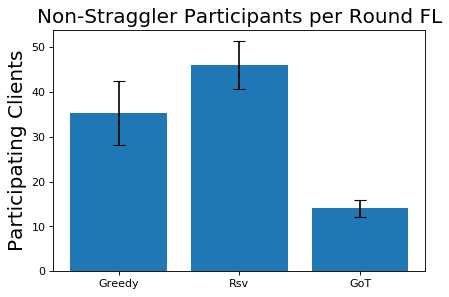

In [5]:

# List to store the loaded dictionaries
dictionaries = []
serve_threshold = 0

# Load dictionaries and append them to the list
num_trial = 5  # Number of trials
for nto in range(num_trial):
    filename = "experiments/save/exp9/23_07_27_participant_array3_" + str(nto) + ".pkl"
    with open(filename, "rb") as file:
        dictionary = pickle.load(file)
        dictionaries.append(dictionary)

# Calculate means and standard deviations
w_means = []
w_stds = []
rsv_means = []
rsv_stds = []
got_means = []
got_stds = []

for dictionary in dictionaries:
    Users_w_sa = dictionary['Users_w_sa']
    Users_rsv_sa = dictionary['Users_rsv_sa']
    GoT_Users_sa = dictionary['GoT_Users_sa']

    w_mean = np.mean(np.sum(Users_w_sa > serve_threshold, axis=0))
    w_std = np.std(np.sum(Users_w_sa > serve_threshold, axis=0))
    rsv_mean = np.mean(np.sum(Users_rsv_sa > serve_threshold, axis=0))
    rsv_std = np.std(np.sum(Users_rsv_sa > serve_threshold, axis=0))
    got_mean = np.mean(np.sum(GoT_Users_sa > serve_threshold, axis=0))
    got_std = np.std(np.sum(GoT_Users_sa > serve_threshold, axis=0))

    w_means.append(w_mean)
    w_stds.append(w_std)
    rsv_means.append(rsv_mean)
    rsv_stds.append(rsv_std)
    got_means.append(got_mean)
    got_stds.append(got_std)

# Plotting the bar graph
labels = ['Greedy', 'Rsv', 'GoT']
values = [np.mean(w_means), np.mean(rsv_means), np.mean(got_means)]
std_values = [np.mean(w_stds), np.mean(rsv_stds), np.mean(got_stds)]

plt.font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 18}
plt.figure(figsize=(6, 4), dpi=80)
plt.bar(labels, values, yerr=std_values, capsize=5)

font = {'family': 'normal',
        'weight': 'normal',
        'size': 18}

plt.rc('font', **font)

# Adding labels and title
plt.ylabel('Participating Clients', fontsize=18)
plt.title('Non-Straggler Participants per Round FL', fontsize=18)
# plt.xlabel('Categories', fontsize=18)
# # Adding labels and title
# plt.ylabel('Participating Clients')
# plt.title('Non-Straggler Participants per Round FL')

# Display the graph"
plt.show()


/home/tkim/anaconda3/lib/python3.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


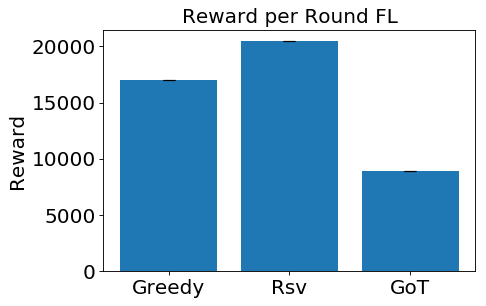

In [6]:

# # List to store the loaded dictionaries
# dictionaries = []
# serve_threshold = 0

# # Load dictionaries and append them to the list
# num_trial = 5  # Number of trials
# for nto in range(num_trial):
#     filename = "experiments/save/exp9/23_07_26_participant_array3_" + str(nto) + ".pkl"
#     with open(filename, "rb") as file:
#         dictionary = pickle.load(file)
#         dictionaries.append(dictionary)

# Calculate means and standard deviations
w_means = []
w_stds = []
rsv_means = []
rsv_stds = []
got_means = []
got_stds = []

for dictionary in dictionaries:
    Users_w_sa = dictionary['Users_w_sa']
    Users_rsv_sa = dictionary['Users_rsv_sa']
    GoT_Users_sa = dictionary['GoT_Users_sa']

    w_mean = np.sum(np.sum(Users_w_sa, axis=1))
    w_std = np.std(np.sum(Users_w_sa, axis=0))
    rsv_mean = np.sum(np.sum(Users_rsv_sa, axis=1))
    rsv_std = np.std(np.sum(Users_rsv_sa, axis=0))
    got_mean = np.sum(np.sum(GoT_Users_sa, axis=1))
    got_std = np.std(np.mean(GoT_Users_sa, axis=0))

    w_means.append(w_mean)
    w_stds.append(w_std)
    rsv_means.append(rsv_mean)
    rsv_stds.append(rsv_std)
    got_means.append(got_mean)
    got_stds.append(got_std)

# Plotting the bar graph
labels = ['Greedy', 'Rsv', 'GoT']
values = [np.mean(w_means), np.mean(rsv_means), np.mean(got_means)]
std_values = [np.mean(w_stds), np.mean(rsv_stds), np.mean(got_stds)]

plt.font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 18}
plt.figure(figsize=(6, 4), dpi=80)
plt.bar(labels, values, yerr=std_values, capsize=5)

font = {'family': 'normal',
        'weight': 'normal',
        'size': 18}

plt.rc('font', **font)

# Adding labels and title
plt.ylabel('Reward', fontsize=18)
plt.title('Reward per Round FL', fontsize=18)
# plt.xlabel('Categories', fontsize=18)
# # Adding labels and title
# plt.ylabel('Participating Clients')
# plt.title('Non-Straggler Participants per Round FL')

# Display the graph"
plt.show()


In [7]:
Users_w_sa.shape

(80, 1000)

In [8]:
got_means

[6628.3036363636365,
 6245.890909090909,
 10166.75,
 11659.053636363638,
 9993.588181818184]

In [9]:
np.sum(Users_w_sa)

16836.298097954546

In [10]:
np.sum(Users_rsv_sa)

20514.60854720909

In [11]:
w_means

[16738.45901069091,
 17005.479233854545,
 17866.586273118184,
 16591.664145936364,
 16836.298097954546]

In [12]:
rsv_means

[20471.188536036367,
 19730.885978136364,
 21542.05721409091,
 20077.609970854544,
 20514.608547209093]

In [13]:
Users_rsv_sa[0]

array([2.87272727e-06, 0.00000000e+00, 2.87272727e-06, 2.87272727e-06,
       0.00000000e+00, 2.87272727e-06, 0.00000000e+00, 2.87272727e-06,
       2.87272727e-06, 0.00000000e+00, 2.87272727e-06, 2.87272727e-06,
       2.87275600e-01, 2.87272727e-06, 0.00000000e+00, 2.87272727e-06,
       2.87272727e-06, 0.00000000e+00, 2.87272727e-06, 2.87275600e-01,
       2.87272727e-06, 2.87272727e-06, 2.87272727e-06, 2.87275600e-01,
       0.00000000e+00, 2.87272727e-06, 0.00000000e+00, 0.00000000e+00,
       2.87272727e-06, 2.87272727e-06, 0.00000000e+00, 2.87272727e-06,
       2.87272727e-06, 2.87272727e-06, 2.87275600e-01, 0.00000000e+00,
       2.87272727e-06, 2.87272727e-06, 0.00000000e+00, 2.87272727e-06,
       0.00000000e+00, 0.00000000e+00, 2.87272727e-06, 2.87275600e-01,
       2.87272727e-06, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       2.87275600e-01, 2.87272727e-06, 2.87275600e-01, 2.87275600e-01,
       2.87275600e-01, 0.00000000e+00, 2.87272727e-06, 0.00000000e+00,
      

In [14]:
Users_w_sa[0]

array([2.87272727e-06, 0.00000000e+00, 2.87272727e-06, 2.87272727e-06,
       0.00000000e+00, 2.87272727e-06, 0.00000000e+00, 2.87272727e-06,
       2.87272727e-06, 0.00000000e+00, 2.87272727e-06, 2.87272727e-06,
       2.87275600e-01, 2.87272727e-06, 0.00000000e+00, 2.87272727e-06,
       2.87272727e-06, 0.00000000e+00, 2.87272727e-06, 2.87275600e-01,
       2.87272727e-06, 2.87272727e-06, 2.87272727e-06, 2.87275600e-01,
       0.00000000e+00, 2.87272727e-06, 0.00000000e+00, 0.00000000e+00,
       2.87272727e-06, 2.87272727e-06, 0.00000000e+00, 2.87272727e-06,
       2.87272727e-06, 2.87272727e-06, 2.87275600e-01, 0.00000000e+00,
       2.87272727e-06, 2.87272727e-06, 0.00000000e+00, 2.87272727e-06,
       0.00000000e+00, 0.00000000e+00, 2.87272727e-06, 2.87275600e-01,
       2.87272727e-06, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       2.87275600e-01, 2.87272727e-06, 2.87275600e-01, 2.87275600e-01,
       2.87275600e-01, 0.00000000e+00, 2.87272727e-06, 0.00000000e+00,
      

In [15]:
Users_w[0].reward_scale[0].shape

(80,)